# Análise do Dataset

In [17]:
import pandas as pd

df = pd.read_csv("../datasets/dataframe_filtrado.csv")
df.shape

(521, 10)

In [18]:
#analise de dados faltantes
qtd_nulls = df.isnull().sum()

print(f"-------------------- Quantidade de dados faltantes por coluna --------------------\n{qtd_nulls}")

print("\n-------------------- Informações do DataFrame --------------------\n")
df.info()

-------------------- Quantidade de dados faltantes por coluna --------------------
B1    0
B2    0
B3    0
B4    0
B5    0
B6    0
B7    0
B8    0
B9    0
RP    0
dtype: int64

-------------------- Informações do DataFrame --------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521 entries, 0 to 520
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   B1      521 non-null    int64 
 1   B2      521 non-null    int64 
 2   B3      521 non-null    int64 
 3   B4      521 non-null    int64 
 4   B5      521 non-null    int64 
 5   B6      521 non-null    int64 
 6   B7      521 non-null    int64 
 7   B8      521 non-null    int64 
 8   B9      521 non-null    int64 
 9   RP      521 non-null    object
dtypes: int64(9), object(1)
memory usage: 40.8+ KB


Remoção de colunas que não irão fazer parte da classificação dos modelos

In [19]:
df_filtrado = df.drop(columns=['Direction', 'Alpha', 'Beta', 'Gama', 'Device', 'Brand', 'Model', 'Created'])
print(f"Nova dimensão dos dados: {df_filtrado.shape}")

print("\n-------------------- Head DataFrame Filtrado --------------------\n")
df_filtrado.head()

KeyError: "['Direction', 'Alpha', 'Beta', 'Gama', 'Device', 'Brand', 'Model', 'Created'] not found in axis"

Conversao do formato da tabela de categorias de str para int

In [20]:
categorias_serie = df_filtrado['RP']
categorias_numeradas= {}
contador = 1

#analise das categorias:
print("------------ Analise das categorias --------------")
for categoria in categorias_serie.unique():
    if(categoria not in categorias_numeradas):
        print(f"Nova categoria encontrada: {categoria}")
        categorias_numeradas[categoria] = contador
        contador += 1


#conversão das categorias de str para int
categorias_serie = categorias_serie.map(categorias_numeradas)
df_filtrado['RP'] = categorias_serie

df_filtrado

------------ Analise das categorias --------------
Nova categoria encontrada: 1
Nova categoria encontrada: 2
Nova categoria encontrada: 3
Nova categoria encontrada: 4
Nova categoria encontrada: 5
Nova categoria encontrada: 6
Nova categoria encontrada: 7
Nova categoria encontrada: 8
Nova categoria encontrada: 9
Nova categoria encontrada: 10
Nova categoria encontrada: 11
Nova categoria encontrada: 12
Nova categoria encontrada: 13
Nova categoria encontrada: 14
Nova categoria encontrada: 15
Nova categoria encontrada: 16
Nova categoria encontrada: 17
Nova categoria encontrada: 18
Nova categoria encontrada: 19
Nova categoria encontrada: 20
Nova categoria encontrada: 21
Nova categoria encontrada: 22
Nova categoria encontrada: 23
Nova categoria encontrada: 24
Nova categoria encontrada: 25
Nova categoria encontrada: 26
Nova categoria encontrada: 27


,B1,B2,B3,B4,B5,B6,B7,B8,B9,RP,X,Y
0,-80,-78,-53,-76,-78,-77,-83,-78,-80,1,6.27,3.76
1,-64,-73,-55,-72,-78,-76,-79,-78,-105,1,6.27,3.76
2,-69,-68,-58,-70,-80,-80,-82,-71,-82,1,6.27,3.76
3,-69,-65,-58,-70,-80,-77,-85,-72,-92,1,6.27,3.76
4,-65,-67,-56,-69,-80,-77,-76,-71,-79,1,6.27,3.76
...,...,...,...,...,...,...,...,...,...,...,...,...
2085,-70,-71,-70,-74,-80,-76,-88,-77,-78,27,6.27,0.77
2086,-69,-72,-70,-74,-80,-78,-89,-78,-77,27,6.27,0.77
2087,-69,-71,-69,-74,-81,-77,-83,-72,-77,27,6.27,0.77
2088,-72,-80,-66,-74,-81,-74,-75,-71,-77,27,6.27,0.77


# Treinamento dos modelos

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Treinamento/Validação com base em RP

Divisão dos dados em Treino e Teste

In [8]:
rssi_colunas = ['B1','B2','B3','B4','B5','B6','B7','B8','B9',]
X_class = df[rssi_colunas].values
Y_class = df['RP'].values


#Mudar o test_size para analisar o resultados
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X_class, Y_class, test_size=0.3, random_state=42, stratify=Y_class)

#conferir se todas as categorias possíveis estao no conjunto de teste
print(np.unique(Y_test_class))

['P_1_1' 'P_1_2' 'P_1_3' 'P_2_1' 'P_2_2' 'P_2_3' 'P_3_1' 'P_3_2' 'P_3_3'
 'P_4_1' 'P_4_2' 'P_4_3' 'P_5_1' 'P_5_2' 'P_5_3' 'P_6_1' 'P_6_2' 'P_6_3'
 'P_7_1' 'P_7_2' 'P_7_3' 'P_8_1' 'P_8_2' 'P_8_3' 'P_9_1' 'P_9_2' 'P_9_3']


Instanciando os objetos necessários para o treinamento

In [10]:
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=42)
param_grid = {'n_neighbors':[1,3,5,7,9,11]}
knn_clf = KNeighborsClassifier()

Treinamento e validação

In [ ]:
grid_search_class = GridSearchCV(knn_clf, param_grid,cv=cv, scoring='accuracy', n_jobs=1)
grid_search_class.fit(X_train_class, Y_train_class)

best_k = grid_search_class.best_params_['n_neighbors']

best_knn_clf = grid_search_class.best_estimator_
Y_pred_class = best_knn_clf.predict(X_test_class)

print("="*60)
print(f"RESULTADOS DA CLASSIFICAÇÃO (PR) - Melhor K: {best_k}")
print("="*60)

print(classification_report(Y_test_class, Y_pred_class))


#plots para analisar os resultados das predicoes de classificacao
print(Y_test_class[:10])
print(Y_pred_class[:10])

RESULTADOS DA CLASSIFICAÇÃO (PR) - Melhor K: 1
              precision    recall  f1-score   support

       P_1_1       0.79      0.97      0.87        35
       P_1_2       1.00      0.91      0.96        35
       P_1_3       0.81      0.83      0.82        35
       P_2_1       0.83      0.83      0.83        35
       P_2_2       0.83      0.86      0.85        35
       P_2_3       0.92      0.94      0.93        35
       P_3_1       0.83      0.50      0.62        20
       P_3_2       0.64      0.80      0.71        20
       P_3_3       0.83      0.75      0.79        20
       P_4_1       0.40      0.30      0.34        20
       P_4_2       0.53      0.50      0.51        20
       P_4_3       0.58      0.55      0.56        20
       P_5_1       0.41      0.35      0.38        20
       P_5_2       0.39      0.45      0.42        20
       P_5_3       0.62      0.79      0.70        19
       P_6_1       0.53      0.50      0.51        20
       P_6_2       0.42      0.40 

# Treinamento com base em (X, Y)

Divisao dos dados

In [ ]:
# Definir Features (RSSI) e Target (Coordenadas X e Y)
X_reg = df[rssi_colunas].values
Y_reg = df[['X', 'Y']].values

# Split dos dados (70% treino, 30% teste)
X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(
    X_reg, Y_reg, test_size=0.3, random_state=42
)

Treinamento e Previsões (Utilizado o mesmo K=5 otimizado na classificação)

In [ ]:
knn_regressor = KNeighborsRegressor(n_neighbors=best_k)
knn_regressor.fit(X_train_reg, Y_train_reg)
Y_pred_reg = knn_regressor.predict(X_test_reg)

Métrica Principal: Erro Médio de Distância (MDE) - Cálculo da Distância Euclidiana entre o ponto real e o ponto predito

In [77]:
squared_error = np.sum(np.square(Y_pred_reg - Y_test_reg), axis=1)
distance_errors = np.sqrt(squared_error)

mde = np.mean(distance_errors)
median_error = np.median(distance_errors)

print("\n\n"+"="*60)
print(f"RESULTADOS DA REGRESSÃO (Localização X, Y) - K: {best_k}")
print("="*60)
print(f"Erro Médio de Distância (MDE): {mde:.2f} unidades")
print(f"Mediana do Erro de Distância: {median_error:.2f} unidades")



RESULTADOS DA REGRESSÃO (Localização X, Y) - K: 5
Erro Médio de Distância (MDE): 1.17 unidades
Mediana do Erro de Distância: 0.82 unidades


Gráfico do Histograma dos Erros de Distância

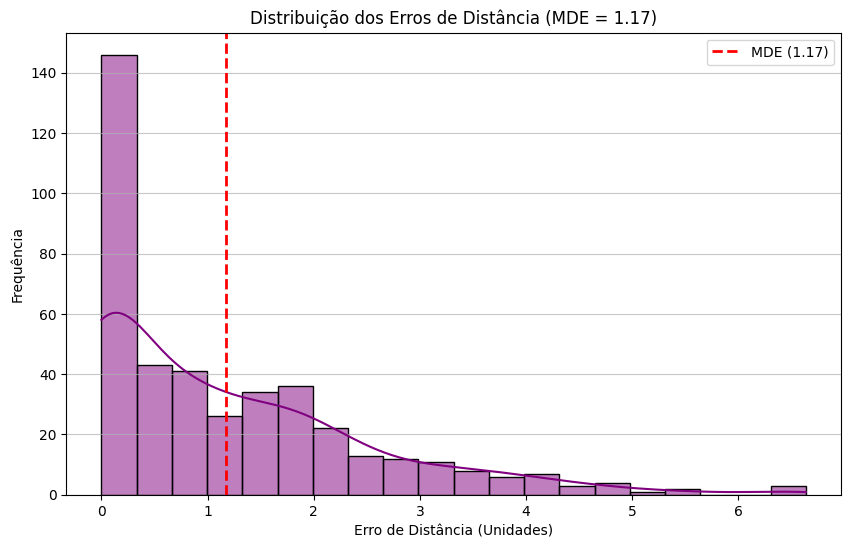

In [78]:
plt.figure(figsize=(10, 6))
sns.histplot(distance_errors, bins=20, kde=True, color='purple')
plt.title(f'Distribuição dos Erros de Distância (MDE = {mde:.2f})')
plt.xlabel('Erro de Distância (Unidades)')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.7)
plt.axvline(mde, color='red', linestyle='dashed', linewidth=2, label=f'MDE ({mde:.2f})')
plt.legend()
plt.savefig("histograma_erros_distancia_final.png")
